In [3]:
# Importing required packages 
import pandas as pd
import matplotlib.pyplot as plt #(plotin histograms in cell #3)
import numpy as np
import scipy.stats as stats
import pandas as pd
import seaborn as sns
#from pomegranate import *
from bayesian import *
#from bayesian.train_bn import structure_learning, parameter_learning
#from preprocess.discretization import get_nodes_type, discretization, code_categories, get_nodes_sign
#from bayesian.save_bn import save_structure, save_params, read_structure, read_params
#from bayesian.sampling import generate_synthetics
#from bayesian.calculate_accuracy import calculate_acc
#from external.libpgm.hybayesiannetwork import HyBayesianNetwork
#from visualization.visualization import draw_BN

from functools import partial

In [4]:
# Defining some constants 
nbins=30

In [5]:
# Reading Data 
energydata = pd.read_csv("./energydata_complete.csv")
# Creating subsamples
# Choosing 10 continous colomns, 'T6','T2','T_out' are the target variables
sample_energydata=energydata[[ 'T1', 'T4', 'T5', 'RH_3','RH_7','RH_9', 'RH_out','T6','T2','T_out']] 
df_sample_colomn_energydata = pd.DataFrame(sample_energydata)

## Step 01 : Sampling of chosen target variables : T2, T_out and Appliance

### Inverse transform sampling

In [6]:
def Inverse_Sampling(dist_fun, column, column_name, num):
    dist_par = dist_fun.fit(column)
    rand = np.random.uniform(size=num)
    sampled = dist_fun(*dist_par)
    sampled_app= sampled.ppf(rand)
    plt.figure()
    sns.distplot(column, kde=True)
    sns.distplot(sampled_app,kde=True, norm_hist=True)
    plt.title('Inverse Transform Sampling for '+ column_name)
    plt.legend(['Original Data', 'Sampled Data'])

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\matplotlib\cbook\__init__.py:1418: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\User\AppDa

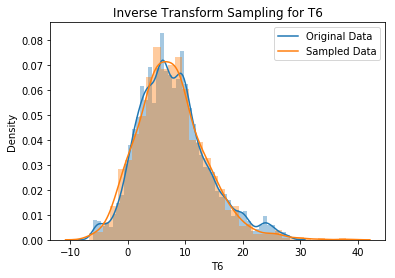

In [7]:
Inverse_Sampling(stats.exponnorm, df_sample_colomn_energydata['T6'], "T6", 1500)

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


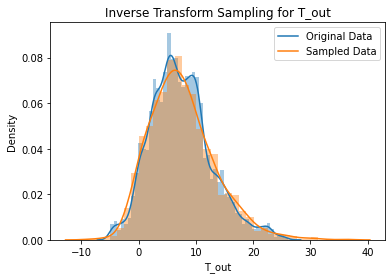

In [32]:
Inverse_Sampling(stats.exponnorm, df_sample_colomn_energydata['T_out'], 'T_out', 1500)

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


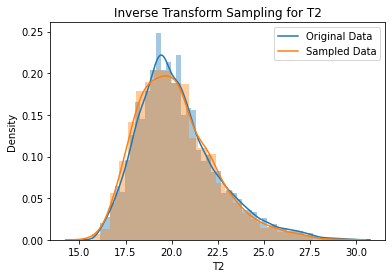

In [35]:
Inverse_Sampling(stats.lognorm, df_sample_colomn_energydata['T2'], 'T2', 1500)

### Accept-Reject sampling


In [14]:
def f(x, mu_, sigma_):
    exp = np.exp(-(np.log(x) - mu_)**2 / (2 * sigma_ ** 2))
    frac = (x * sigma_ * (2 * np.pi) ** 0.5)
    return exp / frac

In [16]:
def g(x, mu, sigma):
    return 1/np.sqrt(2*np.pi)/sigma * np.exp(-0.5*((x-mu)/sigma)**2)

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


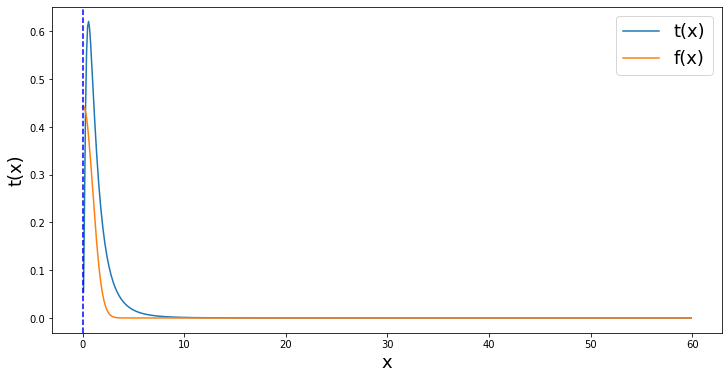

In [19]:
x_vals =  np.arange(0,60,.1)
f_vals = [f(x,0.1,0.8) for x in x_vals]
p_vals =  g (x_vals,0.1,0.9) #[f/NORM_CONST for f in f_vals]

plt.figure(figsize=(12,6))
plt.plot(x_vals, f_vals)

plt.plot(x_vals, p_vals)
plt.legend(['t(x)', 'f(x)'], fontsize = 18)
plt.xlabel('x', fontsize = 18)
plt.ylabel('t(x)', fontsize = 18)
plt.axvline(0, color='b', linestyle='--')

Text(0.5, 1.0, 'M=30')

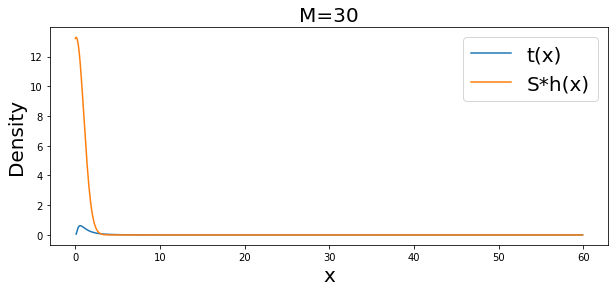

In [246]:
M=30
plt.figure(figsize=(10,4))
plt.plot(x_vals, f_vals)
plt.plot(x_vals, M*p_vals)
plt.xlabel('x', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.legend(['t(x)', 'S*h(x)'], fontsize=20)

plt.title("M=%s"%M, fontsize=20)

In [247]:
#collect all accepted samples here
samples = []

#try this many candidates
N = 100000

for _ in range(N):
    #sample a candidate
    candidate = np.random.normal(0, 0.8)
    
    #calculate probability of accepting this candidate
    prob_accept = f(candidate,0.1,0.8) / (M*g(candidate, 0.1, 0.9))
    
    #accept with the calculated probability
    if np.random.random() < prob_accept:
        samples.append(candidate)

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


Num Samples Collected: 2637
Efficiency: 0.026


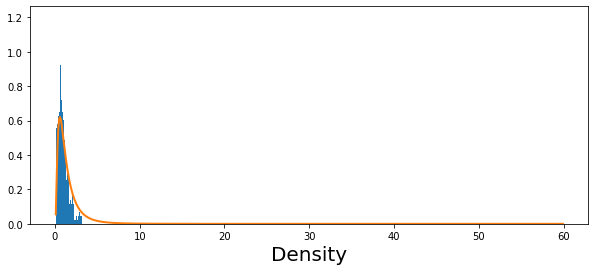

In [249]:
# collect all accepted samples here
samples = []

# try this many candidates
N = 100000

for _ in range(N):
    # sample a candidate
    candidate = np.random.normal(0.1,0.8)

    # calculate probability of accepting this candidate
    prob_accept = f(candidate, 0.1, 0.8) / (M*g(candidate, 0.1,0.9))

    # accept with the calculated probability
    if np.random.random() < prob_accept:
        samples.append(candidate)

plt.figure(figsize=(10, 4))
plt.hist(samples, bins=200, density=True)
plt.xlabel('x', fontsize=20)
plt.xlabel('Density', fontsize=20)
plt.plot(x_vals, [f for f in f_vals], linewidth=2)
# plt.ylim(0, 0.015)
print("Num Samples Collected: %s"%len(samples))
print("Efficiency: %s"%round(len(samples) / N, 3))
# .title('Empirical Exp. Value: %s\nTrue Exp. Value: %s'%(round(np.mean(samples), 2), round(np.mean(TRUE_EXP), 2)), fontsize=20)

## Step 02 relations between predictors and chosen target 

In [275]:
df_sample_colomn_energydata.corr()

,T1,T4,T5,RH_3,RH_7,RH_9,RH_out,T6,RH_2,T2,T_out
T1,1.000000,0.877001,0.885247,-0.028550,0.135182,0.071756,-0.345481,0.654769,-0.002509,0.836834,0.682854
T4,0.877001,1.000000,0.871813,-0.140457,0.043527,-0.025549,-0.388602,0.652350,-0.047304,0.762066,0.663479
T5,0.885247,0.871813,1.000000,-0.050062,0.148905,0.072308,-0.273953,0.629161,0.110409,0.720550,0.651335
RH_3,-0.028550,-0.140457,-0.050062,1.000000,0.832685,0.833538,0.356192,0.076833,0.678326,0.121497,0.118237
RH_7,0.135182,0.043527,0.148905,0.832685,1.000000,0.858686,0.378519,0.256077,0.690584,0.229212,0.294222
RH_9,0.071756,-0.025549,0.072308,0.833538,0.858686,1.000000,0.359377,0.184424,0.676467,0.157346,0.223282
RH_out,-0.345481,-0.388602,-0.273953,0.356192,0.378519,0.359377,1.000000,-0.569119,0.584911,-0.505291,-0.574186
T6,0.654769,0.652350,0.629161,0.076833,0.256077,0.184424,-0.569119,1.000000,-0.009670,0.801186,0.974778
RH_2,-0.002509,-0.047304,0.110409,0.678326,0.690584,0.676467,0.584911,-0.009670,1.000000,-0.165610,0.033703
T2,0.836834,0.762066,0.720550,0.121497,0.229212,0.157346,-0.505291,0.801186,-0.165610,1.000000,0.792247


## Step 04 Bayesian network for chosen set of variables. Choose its structure on the basis of multivariate analysis and train distributions in nodes using chosen algorithm

In [285]:
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination

In [306]:
names=['T1', 'T4', 'T5', 'RH_3','RH_7','RH_9', 'RH_out','T6','T2','T_out']
bayes_manual = dict(
    {'V': ['T1', 'T4', 'T5', 'RH_3','RH_7','RH_9', 'RH_out','T6','T2','T_out'],
     'E': [   
        ['T_out', 'T6'],
        ['T2', 'T6'],
        ['T4', 'T6'],

        ['T1', 'T2'],
        ['T6', 'T2'],
        ['T_out', 'T2'],
        ['T4', 'T2'],
        ['T5', 'T2'],


        ['T2', 'T_out'],
        ['T6', 'T_out'],
        ['T1', "T_out"],
        ['T4', "T_out"],
        ['T5', "T_out"]
    ]
    }
)
model=BayesianModel([   
        ['T_out', 'T6'],
        ['T2', 'T6'],
        ['T4', 'T6'],
        ['T1', 'T2'],
        ['T2', 'T_out'],
        ['T1', 'T_out'],
    ])

In [307]:
infer=VariableElimination(model)

ValueError: No CPD associated with T_out

In [ ]:
names=['T1', 'T4', 'T5', 'RH_3','RH_7','RH_9', 'RH_out','T6','T2','T_out')
bayes_manual = dict(
    {'V': ['T1', 'T4', 'T5', 'RH_3','RH_7','RH_9', 'RH_out','T6','T2','T_out'],
     'E': [    'T6','T2','T_out'
        ['T_out', 'T6'],
        ['T2', 'T6'],
        ['T4', 'T6'],

        ['52 Week High', 'T2'],
        ['52 Week Low', 'T2'],
        ['Price', 'T2'],


        ['52 Week High', 'T_out'],
        ['Price/Sales', 'T_out'],
        ['Price', "T_out"]
    ]
    }
)

## Step 05

In [ ]:
coded_data, coder = code_categories(
    data, 'label', ['Sector'])
discrete_data, coder = discretization(coded_data, 'equal_frequency',
                                      ['Price',	'Price/Earnings', 'Dividend Yield',	'Earnings/Share',
                                       '52 Week Low',	'52 Week High',	'Market Cap',	'EBITDA',
                                       'Price/Sales',	'Price/Book'])
bayes_hc = structure_learning(discrete_data, 'HC', nodes_type, 'K2')
print("Obtained network structure", bayes_hc)
draw_BN(bayes_hc, nodes_type, 's&p_bayes_hc')


params = parameter_learning(data, nodes_type, bayes_hc, 'simple')
save_structure(bayes_hc, 's&p_bayes_hc_structure')
skel = read_structure('s&p_bayes_hc_structure')
save_params(params, 'p_bayes_hc_params')
params = read_params('p_bayes_hc_params')
bayes_hc = HyBayesianNetwork(skel, params)
synth_df = generate_synthetics(bayes_hc, nodes_sign, 'simple', 800)

fix, ax = plt.subplots(3, 1, figsize=(10, 12))

sns.distplot(data['Price'], ax=ax[0])
sns.distplot(synth_df['Price'], ax=ax[0])
ax[0].legend(['Real data', 'Synthesized data'])

sns.distplot(data['Dividend Yield'], ax=ax[1])
sns.distplot(synth_df['Dividend Yield'], ax=ax[1])
ax[1].legend(['Real data', 'Synthesized data'])

sns.distplot(data['Earnings/Share'], ax=ax[2])
sns.distplot(synth_df['Earnings/Share'], ax=ax[2])
ax[2].legend(['Real data', 'Synthesized data'])

print(calculate_acc(bayes_hc, data, [
      'Price', 'Dividend Yield', 'Earnings/Share'], 'simple')[0:2])